# 04 Technical Failure Analysis (GMF)

**Purpose**  
Analyze GMF technical failure labels and their co-occurrence with AI goals and technologies at descriptive level.

**Outputs preserved:**
- `60_gmf_failures_top15.png`
- `61_gmf_failures_percent.png`

## Configuration

In [13]:
import sys
from pathlib import Path
import pandas as pd
from IPython.display import display

PROJECT_ROOT = next((p for p in [Path.cwd(), *Path.cwd().parents] if (p / "src").exists()), Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.notebook_utils import ensure_output_dir, load_data, pick_column_by_keywords, plot_barh_top, plot_percent_barh

DATA_PATH = PROJECT_ROOT / "data"
OUTPUT_PATH = ensure_output_dir(PROJECT_ROOT / "outputs" / "figures")
TOP_N = 15
DATE_CANDIDATES = ["date"]

loaded_tables = load_data(DATA_PATH, tables=["incidents", "gmf"])
incidents_df = loaded_tables["incidents"]
gmf_df = loaded_tables["gmf"]

if incidents_df is None or gmf_df is None:
    raise FileNotFoundError("Required tables missing: incidents.csv or classifications_GMF.csv.")

print("GMF:", gmf_df.shape)
print("Incidents:", incidents_df.shape)

failure_col = pick_column_by_keywords(gmf_df, ["failure"], nice_to_have=["technical", "known", "ai"])
goal_col = pick_column_by_keywords(gmf_df, ["goal"], nice_to_have=["known", "ai"])
tech_col = pick_column_by_keywords(gmf_df, ["technology"], nice_to_have=["known", "ai"])

print("Chosen failure column:", failure_col)
print("Chosen goal column:", goal_col)
print("Chosen technology column:", tech_col)

if failure_col is None:
    print("No failure-like column found. Candidates containing 'fail':", [c for c in gmf_df.columns if "fail" in c])
else:
    if gmf_df[failure_col].dropna().empty:
        print(f"Warning: {failure_col} exists but is entirely null in this snapshot.")
    print("Distinct failure labels:", gmf_df[failure_col].nunique(dropna=True))
    print("Top 5 failure labels:", gmf_df[failure_col].dropna().astype(str).value_counts().head(5).to_dict())

GMF: (326, 21)
Incidents: (1367, 9)
Chosen failure column: known_ai_technical_failure_snippets
Chosen goal column: known_ai_goal
Chosen technology column: known_ai_technology_snippets
Distinct failure labels: 282
Top 5 failure labels: {'Snippet Text: \n': 2, 'Snippet Text: \nPart of YouTube’s plan is to increase human moderation and tweak its algorithm, “training machine-learning technology across other challenging content areas, including child safety and hate speech.” YouTube will also cut down on channels that receive monetization and advertisements attached to these videos. Since YouTube Kids also includes ads — many of which, Golin says, aren’t child appropriate — this will affect channels and videos on the platform.\nRelated Classifications: Tuning Issues\n, Snippet Text: "Recommendations are designed to optimize watch time, there is no reason that it shows content that is actually good for kids. \nRelated Classifications: Tuning Issues\n, Snippet Text: On YouTube today, children

## Failure Distributions

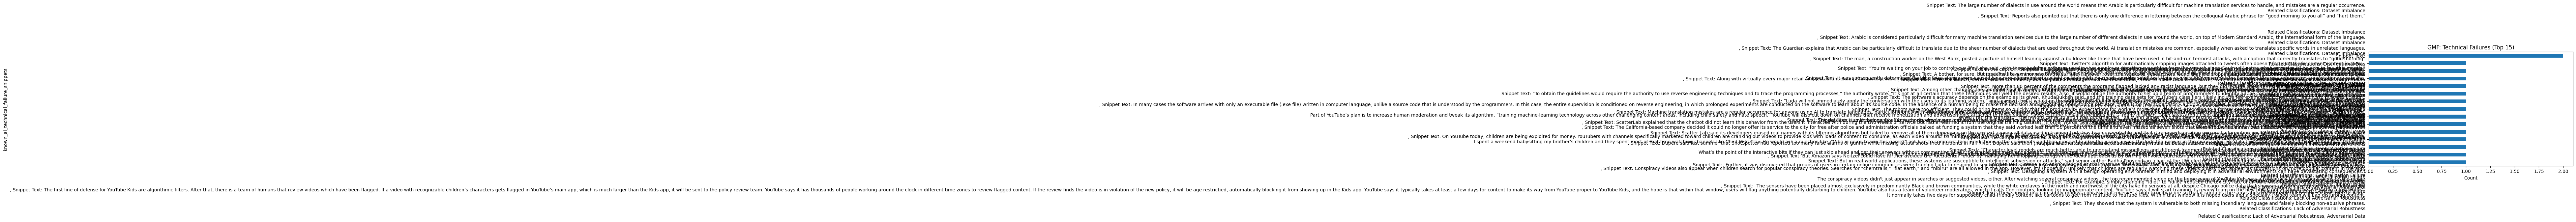

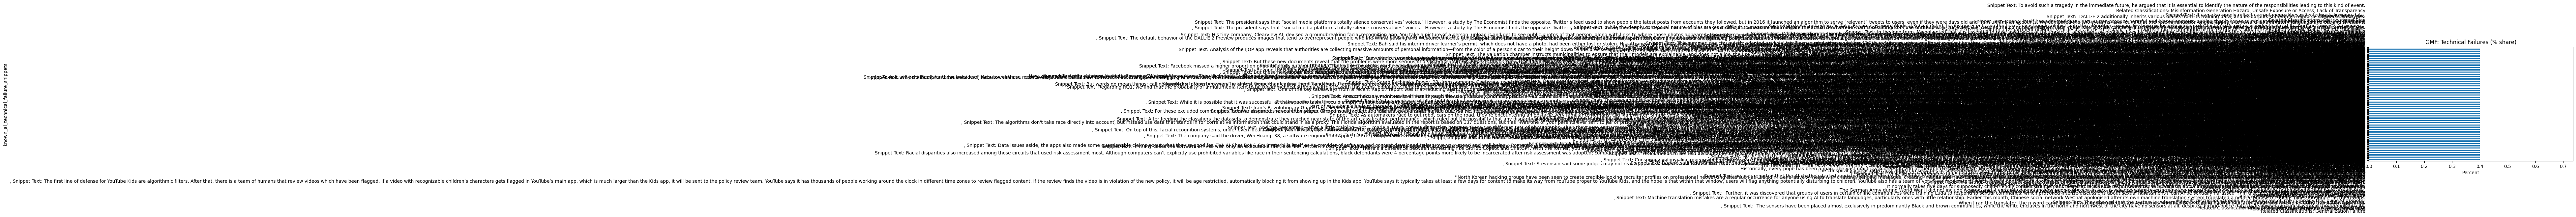

In [14]:
if failure_col is None:
    print("Cannot proceed: GMF failure column not found.")
else:
    plot_barh_top(
        gmf_df[failure_col],
        "GMF: Technical Failures (Top 15)",
        "Count",
        OUTPUT_PATH / "60_gmf_failures_top15.png",
        top_n=TOP_N,
    )
    plot_percent_barh(
        gmf_df[failure_col],
        "GMF: Technical Failures (% share)",
        OUTPUT_PATH / "61_gmf_failures_percent.png",
    )

## Co-occurrence Tables

In [15]:
if failure_col and goal_col:
    failure_goal_df = gmf_df.dropna(subset=[failure_col, goal_col]).copy()
    failure_goal_df[failure_col] = failure_goal_df[failure_col].astype(str)
    failure_goal_df[goal_col] = failure_goal_df[goal_col].astype(str)

    top_goals = failure_goal_df[goal_col].value_counts().head(8).index
    failure_goal_df = failure_goal_df[failure_goal_df[goal_col].isin(top_goals)]

    failure_by_goal_pct = (pd.crosstab(failure_goal_df[goal_col], failure_goal_df[failure_col], normalize="index") * 100).round(1)
    print("Failures by Goal (% within goal):")
    display(failure_by_goal_pct.iloc[:, :10])
else:
    print("Skipping Failures-by-Goal: missing goal or failure column.")

Failures by Goal (% within goal):


known_ai_technical_failure_snippets,Snippet Text: \n,"Snippet Text: In a tweet, Tesla CEO Elon Musk said that the vehicle's radar didn't help in this case because it ""tunes out what looks like an overhead road sign to avoid false braking events.""\nRelated Classifications: Generalization Failure, Limited Dataset\n, Snippet Text: Because of the high ride-height of the trailer, as well as its positioning across the road, the Model S passed under the trailer and the first impact was between the windshield and the trailer.\nRelated Classifications: Generalization Failure, Limited Dataset\n, Snippet Text: The company said the driver, Wei Huang, 38, a software engineer for Apple, had received several visual and audible warnings to put his hands back on the steering wheel but had failed to do so, even though his Model X S.U.V. had the modified version of the software. His hands were not detected on the wheel for six seconds before his Model X slammed into a concrete divider near the junction of Highway 101 and 85 in Mountain View, and neither Mr. Huang nor the Autopilot activated the brakes before the crash.\nRelated Classifications: Generalization Failure\n","Snippet Text: ""Hochholdinger's view is that robots could be a much bigger factor in auto production than they are currently, largely because many components are designed to be assembled by humans, not machines.""\nRelated Classifications: Problematic Input, Task Mismatch\n, Snippet Text: A majority of costs in AI is upfront, this upfront cost can spiral out of control if the problem is beyond what present-day AI is capable of doing.\nRelated Classifications: Task Mismatch\n","Snippet Text: ""I'm having my period, wanna take a rest,"" it is said to have responded.\nRelated Classifications: Distributional Artifacts\nSnippet Discussion: Chatbot hallucinates.\n, Snippet Text: For example, if a user asked Baby Q, ""Have you eaten?"" they would get the response, ""I haven't eaten; I don't have an appetite.""\nRelated Classifications: Distributional Artifacts\n, Snippet Text: One user posted the comment ""Long live the Communist Party,"" and received a response from Baby Q asking, ""Do you think that such a corrupt and incompetent political regime can live forever?""\nRelated Classifications: Distributional Bias\n, Snippet Text: Apple Daily has said it spoke to a former Tencent employee who argued the app had clearly been developed with universal values in mind, and not ""Chinese characteristics"".\nRelated Classifications: Context Misidentification, Distributional Artifacts\n","Snippet Text: #gpt3 is surprising and creative but it’s also unsafe due to harmful biases. Prompted to write tweets from one word - Jews, black, women, holocaust - it came up with these (https://thoughts.sushant-kumar.com). We need more progress on #ResponsibleAI before putting NLG models in production.\nRelated Classifications: Distributional Bias\n","Snippet Text: A damning 2018 report by Stanford researcher and PhD candidate Becca Lewis describes the alternative media system on YouTube that fed young viewers far-right propaganda. \nRelated Classifications: Unsafe Exposure or Access, Misinformation Generation Hazard\n","Snippet Text: A deepfake video of Ukrainian president Volodymyr Zelenksy calling on his country’s troops to surrender to Russian forces reportedly made it onto a hacked Ukrainian news site today after going viral on Facebook, \nRelated Classifications: Misinformation Generation Hazard, Unsafe Exposure or Access\n","Snippet Text: A fake sexually explicit video of podcast host Bobbi Althoff spread rapidly on X Tuesday afternoon, adding to the platform’s recent challenges in cracking down on deepfakes of female celebrities.\nRelated Classifications: Misinformation Generation Hazard, Unsafe Exposure or Access\n","Snippet Text: A recent study conducted by researchers from Stanford and McMaster universities found that GPT-3 generates novel statements of bigotry. In other words: GPT-3 can generate

In [16]:
if failure_col and tech_col:
    failure_tech_df = gmf_df.dropna(subset=[failure_col, tech_col]).copy()
    failure_tech_df[failure_col] = failure_tech_df[failure_col].astype(str)
    failure_tech_df[tech_col] = failure_tech_df[tech_col].astype(str)

    top_technologies = failure_tech_df[tech_col].value_counts().head(8).index
    failure_tech_df = failure_tech_df[failure_tech_df[tech_col].isin(top_technologies)]

    failure_by_tech_pct = (pd.crosstab(failure_tech_df[tech_col], failure_tech_df[failure_col], normalize="index") * 100).round(1)
    print("Failures by Technology (% within technology):")
    if failure_by_tech_pct.shape[1] == 0:
        print("Crosstab produced no columns (likely sparse labels).")
    else:
        display(failure_by_tech_pct.iloc[:, :min(10, failure_by_tech_pct.shape[1])])
else:
    print("Skipping Failures-by-Technology: missing technology or failure column.")

Failures by Technology (% within technology):


known_ai_technical_failure_snippets,"Snippet Text: \nPart of YouTube’s plan is to increase human moderation and tweak its algorithm, “training machine-learning technology across other challenging content areas, including child safety and hate speech.” YouTube will also cut down on channels that receive monetization and advertisements attached to these videos. Since YouTube Kids also includes ads — many of which, Golin says, aren’t child appropriate — this will affect channels and videos on the platform.\nRelated Classifications: Tuning Issues\n, Snippet Text: ""Recommendations are designed to optimize watch time, there is no reason that it shows content that is actually good for kids. \nRelated Classifications: Tuning Issues\n, Snippet Text: On YouTube today, children are being exploited for money. YouTubers with channels specifically marketed toward children are cranking out videos to provide kids with loads of content to consume, as each video around 16 minutes long. (Which is the sweet spot for maximum ad revenue.) Frankly, YouTubers are practically begging their viewers to “smash” that like button and comment on their videos.\nI spent a weekend babysitting my brother’s children and they spent most of that time watching channels like Chad Wild Clay. He would ask a question like, “Who is going to win this game?” ask kids to comment their predictions in the comments and then proceed to play the game, giving the kids the answer in the same video. He’d do that same thing several times throughout the video.\n\nWhat’s the point of the interactive bits if they can just skip ahead and get their answers without commenting at all? It’s simple: the more engagement the video gets, the more likely it is to be picked up by YouTube’s recommendation algorithm, thus bringing in more traffic and more money.\nRelated Classifications: Tuning Issues\nSnippet Discussion: Recommendation training / video ranking is utilizing likes and engagement too much.\n, Snippet Text: Conspiracy videos also appear when children search for popular conspiracy theories. Searches for ""chemtrails,"" ""flat earth,"" and ""nibiru"" are all allowed in the app. However, it's (hopefully) unlikely that children are regularly watching these videos unless they appear as suggestions on more popular content in the app.\n\nThe conspiracy videos didn't just appear in searches or suggested videos, either. After watching several conspiracy videos, the top recommended video on the home page of YouTube Kids was a conspiracy theory about aliens on the moon:\nRelated Classifications: Tuning Issues\n, Snippet Text: The first line of defense for YouTube Kids are algorithmic filters. After that, there is a team of humans that review videos which have been flagged. If a video with recognizable children’s characters gets flagged in YouTube’s main app, which is much larger than the Kids app, it will be sent to the policy review team. YouTube says it has thousands of people working around the clock in different time zones to review flagged content. If the review finds the video is in violation of the new policy, it will be age restrictied, automatically blocking it from showing up in the Kids app. YouTube says it typically takes at least a few days for content to make its way from YouTube proper to YouTube Kids, and the hope is that within that window, users will flag anything potentially disturbing to children. YouTube also has a team of volunteer moderators, which it calls Contributors, looking for inappropriate content. YouTube says it will start training its review team on the new policy and it should be live within a few weeks. \nIt normally takes five days for supposedly child-friendly content like cartoons to get from YouTube to YouTube Kids. Within that window it is hoped users and a specially-trained team will flag disturbing content.\n\n\n\nRelated Classifications: Lack of Adversarial Robustness, Adversarial Data\n","Snippet Text: Alexa is not without its SNAFUs when it comes to

In [17]:
if "incident_id" in gmf_df.columns and "incident_id" in incidents_df.columns:
    gmf_incidents = gmf_df.dropna(subset=["incident_id"]).copy()
    gmf_incidents["has_failure_label"] = gmf_incidents[failure_col].notna() if failure_col else False

    incident_failure_flags = (
        gmf_incidents.groupby("incident_id")["has_failure_label"]
        .max()
        .reset_index()
        .rename(columns={"has_failure_label": "gmf_has_failure"})
    )

    incident_core_df = incidents_df[["incident_id"]].drop_duplicates().merge(incident_failure_flags, on="incident_id", how="left")
    incident_core_df["gmf_has_failure"] = incident_core_df["gmf_has_failure"].fillna(False)

    print("Incidents with GMF failure labels:", incident_core_df["gmf_has_failure"].sum())
    print("Share of incidents with GMF failure labels:", f"{incident_core_df['gmf_has_failure'].mean():.1%}")
else:
    print("Missing incident_id in GMF or incidents table; cannot compute incident-level tagging.")

Incidents with GMF failure labels: 283
Share of incidents with GMF failure labels: 20.7%


## Interpretation and Responsible Notes

- GMF coverage is a subset of incidents, so failure distributions apply to labeled records only.
- Co-occurrence tables are descriptive and do not imply causality.
- Defensive guards preserve deterministic execution when optional columns are missing.